In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm import trange

import pymc as pm

from pymc_extras.inference.advi.autoguide import AutoDiagonalNormal
from pymc_extras.inference.advi.training import compile_svi_training_fn, compile_sampling_fn

In [2]:
with pm.Model() as m:
    X = pm.Normal("X", 0, 1, size=(100, 3))
    alpha = pm.Normal("alpha", 0, 10)
    beta = pm.Normal("beta", 0, 5, size=(3,))

    mu = alpha + X @ beta
    sigma = pm.HalfNormal("sigma", 1)
    y = pm.Normal("y", mu=mu, sigma=sigma)

    prior = pm.sample_prior_predictive(random_seed=38)

Sampling: [X, alpha, beta, sigma, y]


In [3]:
draw = 123
true_params = {}
true_params["alpha"] = prior.prior.alpha.sel(chain=0, draw=draw).values
true_params["beta"] = prior.prior.beta.sel(chain=0, draw=draw).values
true_params["sigma"] = prior.prior.sigma.sel(chain=0, draw=draw).values

X_data = prior.prior.X.sel(chain=0, draw=draw).values
y_data = prior.prior.y.sel(chain=0, draw=draw).values

In [4]:
true_params

{'alpha': array(11.82213038),
 'beta': array([-0.92518728,  0.27270752, -0.20081106]),
 'sigma': array(0.40007044)}

In [5]:
m_obs = pm.observe(pm.do(m, {X: X_data}), {"y": y_data})

In [6]:
with m_obs:
    idata = pm.sample(mp_ctx="spawn")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [7]:
from pymc_extras.inference.advi.training import SVIModule, SVITrainer, SVIState
from typing import Any


class SGDOptimizer:
    def __init__(self, learning_rate: float = 1e-5):
        self.learning_rate = learning_rate

    def init(self, params: dict[str, np.ndarray]) -> None:
        return None

    def update(
        self,
        grads: dict[str, np.ndarray],
        state: None,
        params: dict[str, np.ndarray],
    ) -> tuple[dict[str, np.ndarray], None]:
        updated_params = {k: v - self.learning_rate * grads[k] for k, v in params.items()}
        return updated_params, state


class NormalModel(SVIModule):
    def configure_guide(self, model):
        return AutoDiagonalNormal(model)

    def configure_optimizer(self, params: dict[str, np.ndarray]) -> tuple[Any, dict[str, Any]]:
        optimizer = SGDOptimizer(learning_rate=1e-5)
        opt_state = optimizer.init(params)
        return optimizer, opt_state

    def apply_gradients(
        self,
        params: dict[str, np.ndarray],
        grads: dict[str, np.ndarray],
        optimizer: Any,
        optimizer_state: dict[str, Any],
    ):
        updated_params, updated_opt_state = optimizer.update(grads, optimizer_state, params)
        return updated_params, updated_opt_state


def plot_loss_history(state, window_size=100):
    kernel = np.full(window_size, 1 / window_size)
    loss_history = np.stack(state.loss_history)
    plt.plot(np.convolve(loss_history, kernel, mode="valid"))

In [8]:
svi_trainer = SVITrainer(module=NormalModel(), compile_kwargs={"mode": "NUMBA"})

In [9]:
svi_state = svi_trainer.fit(n_steps=2000, model=m_obs, draws_per_step=500)

Output()

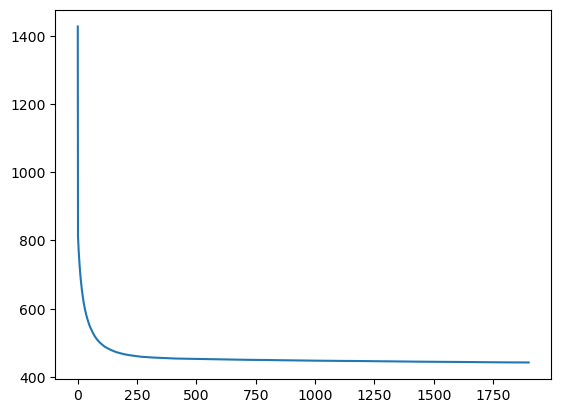

In [10]:
plot_loss_history(svi_state)

Output()

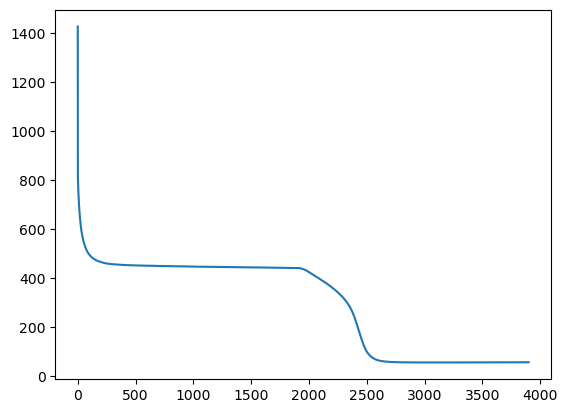

In [11]:
svi_trainer._optimizer.learning_rate = 1e-3
svi_state = svi_trainer.fit(state=svi_state, n_steps=2000, model=m_obs, draws_per_step=500)
plot_loss_history(svi_state)

In [12]:
def inverse_softplus(x):
    return np.log(np.expm1(x))


mcmc_param_values = {}
mcmc_param_values["sigma_loc"] = np.log(idata.posterior["sigma"]).mean(("chain", "draw")).values
mcmc_param_values["sigma_scale"] = inverse_softplus(
    np.log(idata.posterior["sigma"]).std(("chain", "draw"))
).values

for param in ("beta", "alpha"):
    mcmc_param_values[f"{param}_loc"] = idata.posterior[param].mean(("chain", "draw")).values
    mcmc_param_values[f"{param}_scale"] = inverse_softplus(
        idata.posterior[param].std(("chain", "draw"))
    ).values

In [13]:
optimized_params = svi_state.params
optimized_params

{'sigma_loc': np.float64(-1.0831210783583385),
 'sigma_scale': np.float64(-3.3890538394368788),
 'beta_loc': array([-0.91010212,  0.27346576, -0.16000572]),
 'beta_scale': array([-3.84732163, -3.86653825, -3.75028701]),
 'alpha_loc': np.float64(11.782832520195816),
 'alpha_scale': np.float64(-3.862770284050732)}

In [14]:
mcmc_param_values

{'sigma_loc': array(-1.06674151),
 'sigma_scale': array(-2.59106729),
 'beta_loc': array([-0.90903775,  0.27267895, -0.16003761]),
 'beta_scale': array([-3.29209512, -3.33303361, -3.19913288]),
 'alpha_loc': array(11.78199793),
 'alpha_scale': array(-3.33625442)}

In [15]:
with m_obs:
    idata_vi = svi_trainer.sample_posterior(draws=1000, state=svi_state)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

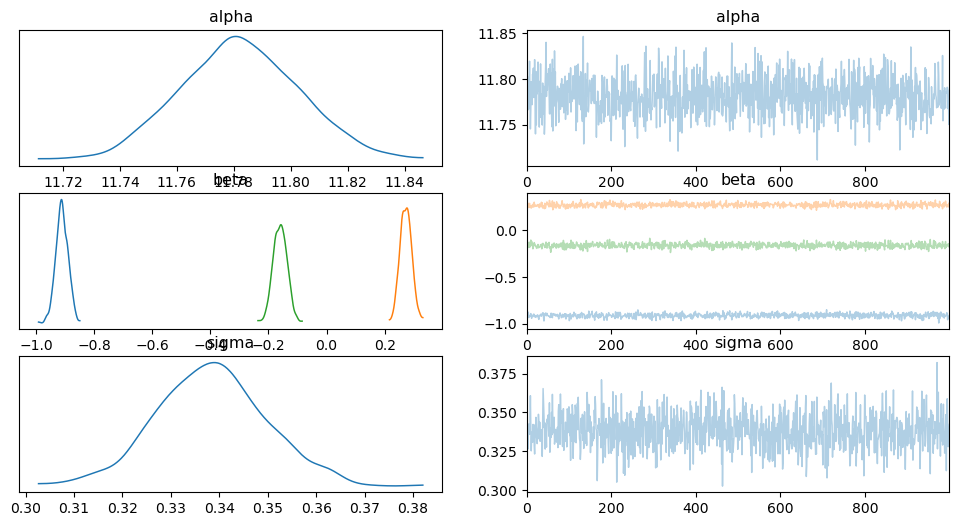

In [16]:
import arviz as az

az.plot_trace(idata_vi, var_names=["alpha", "beta", "sigma"])

In [17]:
true_params

{'alpha': array(11.82213038),
 'beta': array([-0.92518728,  0.27270752, -0.20081106]),
 'sigma': array(0.40007044)}

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'sigma'}>, <Axes: >]], dtype=object)

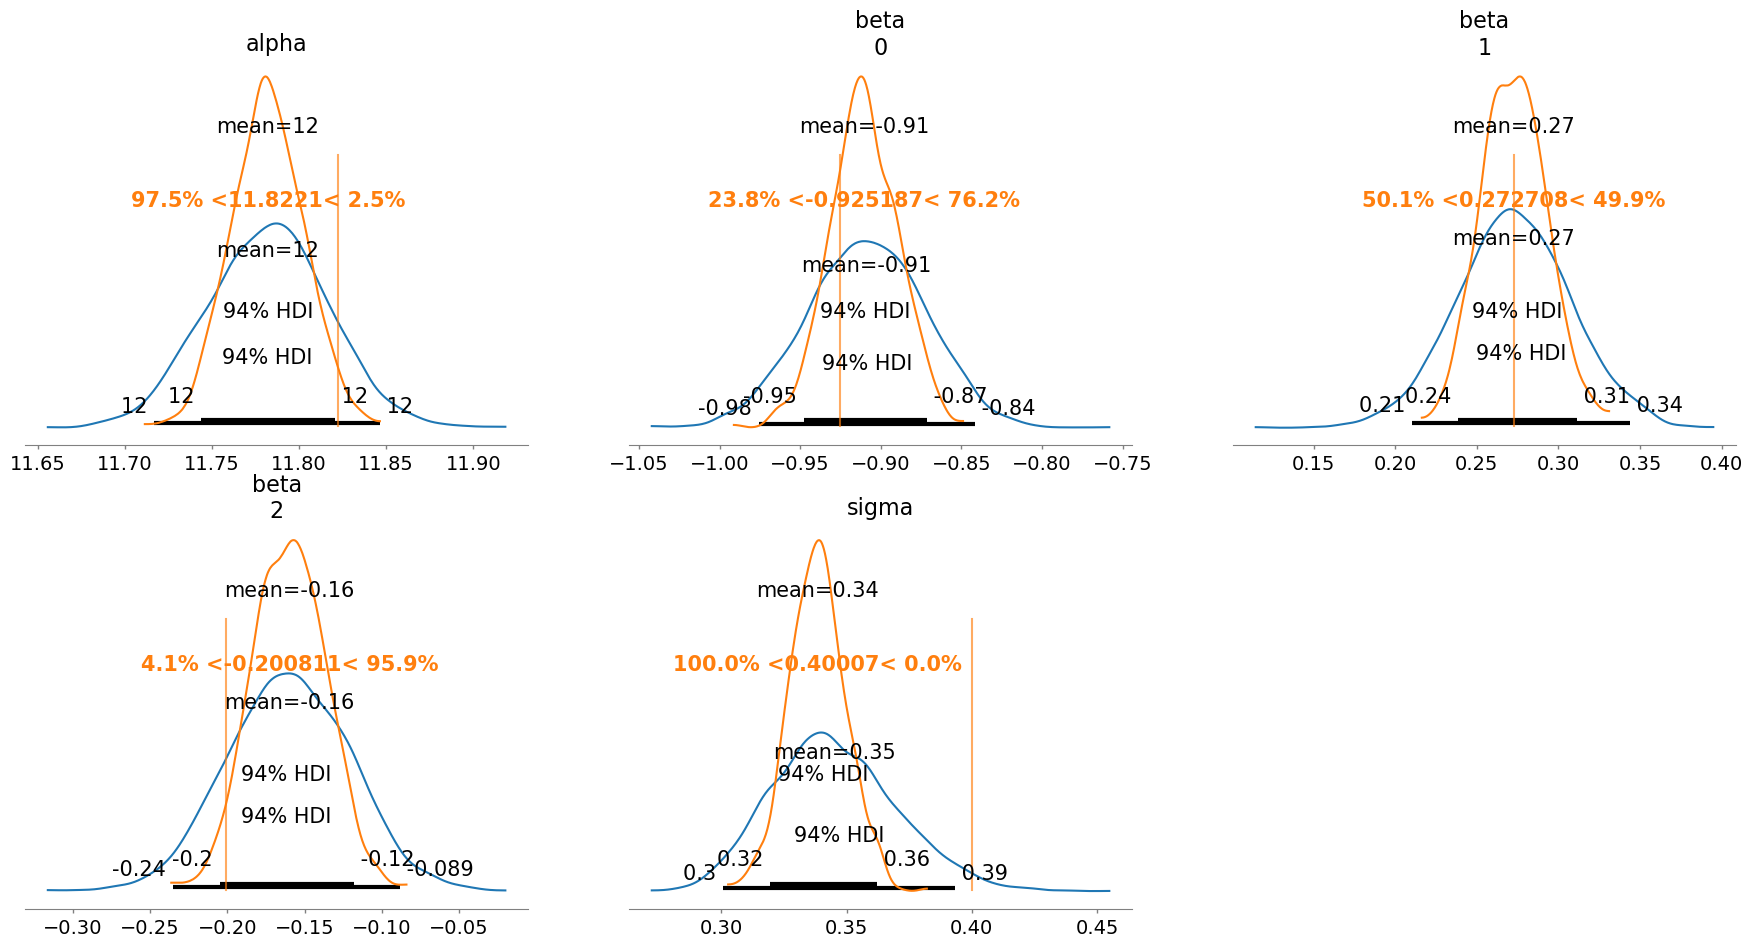

In [18]:
var_names = ["alpha", "beta", "sigma"]
axes = az.plot_posterior(idata, color="tab:blue", var_names=var_names)
az.plot_posterior(
    idata_vi,
    color="tab:orange",
    var_names=var_names,
    ref_val=np.r_[*[true_params[v] for v in var_names]].tolist(),
    ax=axes,
)

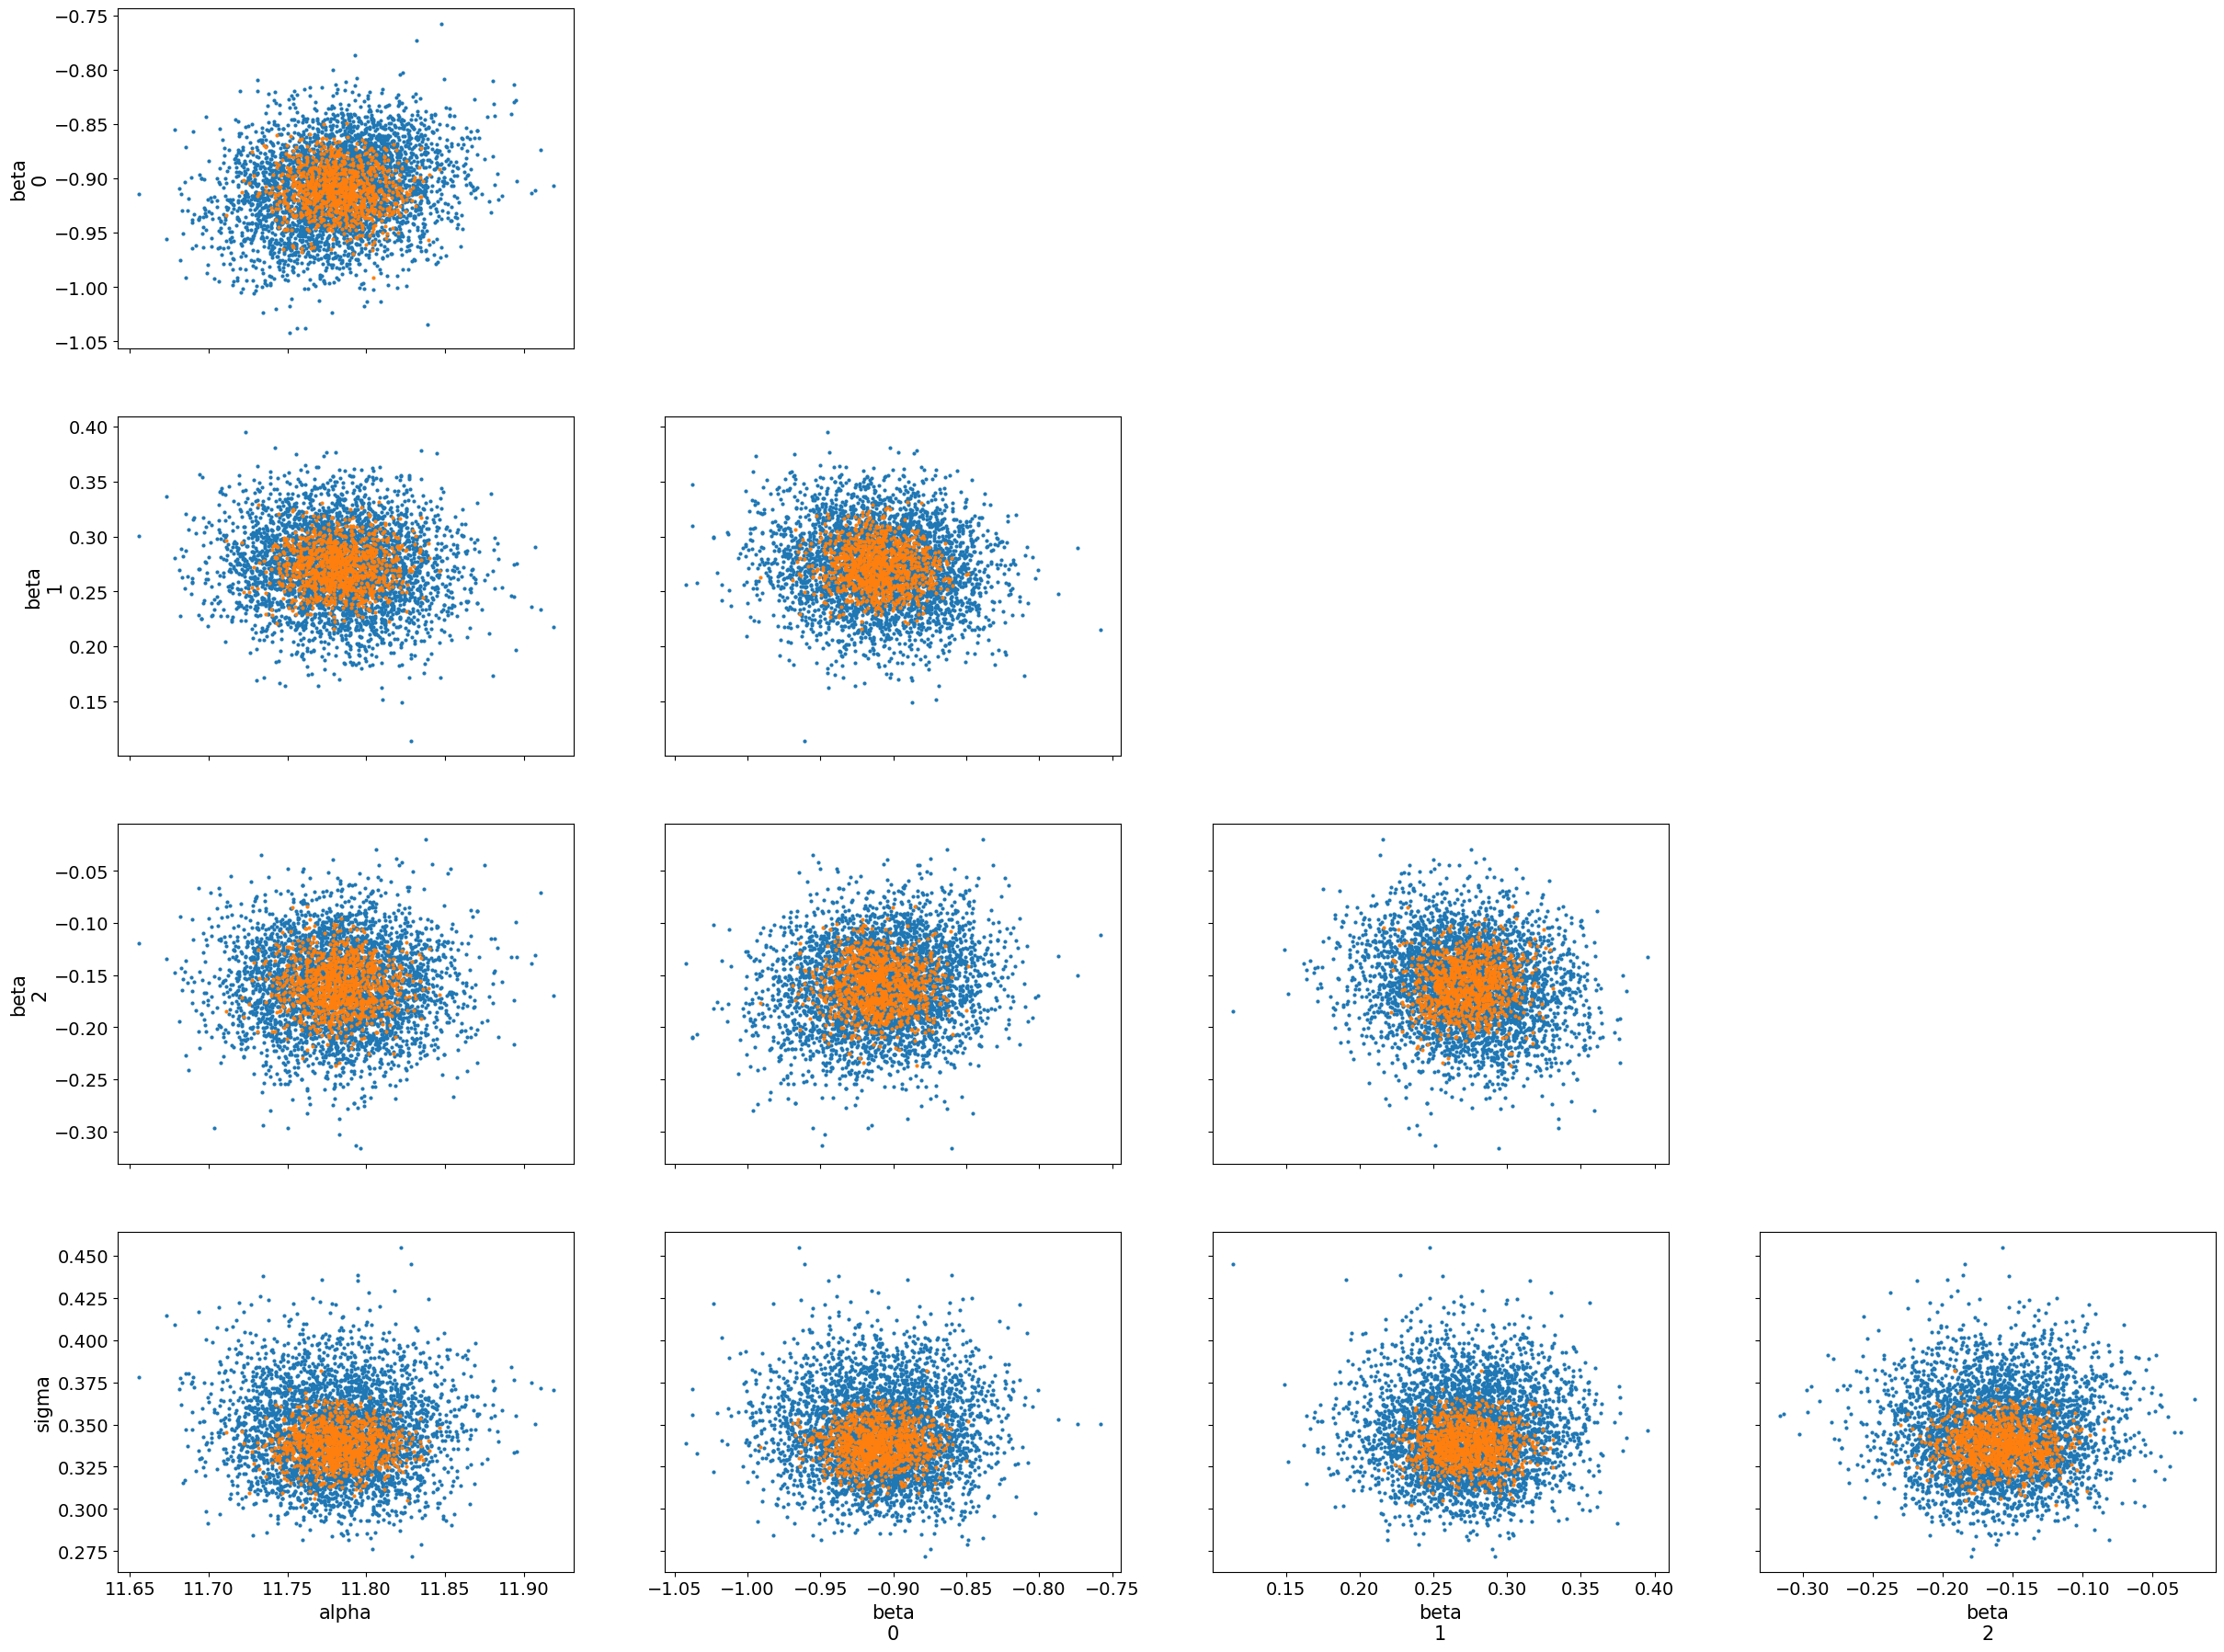

In [19]:
axes = az.plot_pair(idata, var_names=var_names)
az.plot_pair(idata_vi, var_names=var_names, ax=axes)
plt.show()

## Todo:

- Does this "two models" frameworks fits into what we already have?
- rsample --> stochastic gradients? Or automatic reparameterization?
- figure out guide param initalization
- More flexible optimizers...